In [4]:
import sys
sys.path.append('../src')
from logger import log, debug
from cleaner import clean_corpus_basic_neutral
from reader import read_files
from nb_utils import get_best_tokens_dummy

from sklearn.utils import shuffle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle
import nltk

In [5]:
# -------------- Hiperparametros -----------------

min_each_q = 60
max_each_q = 70
interval = 1
min_lenght, max_length = 4, 8
train_to_test = 0.8

In [6]:
# Leemos los archivos
neutral_corpus_raw = pd.read_csv("./samples/neutral_human_rated.csv")
# Limpiamos el dataframe
neutral_corpus = clean_corpus_basic_neutral(neutral_corpus_raw)

debug("[El corpus tiene " + str(len(neutral_corpus)) + " rows]")

#Shuffleamos el corpus
neutral_corpus = shuffle(neutral_corpus)
neutral_corpus.reset_index(inplace=True, drop=True)
neutral_corpus.head()


pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 200)


[Usando cleaner basico para samples neutrales]
[Limpiando el corpus...]
[Usando 8 threads ...]
[El corpus tiene 1000 rows]


In [7]:

def to_nb_dictionaty(cleaned_sentence, best_tokens):
    to_ret = {}
    for item in best_tokens.iteritems():
        to_ret[item[0]] = 0
    tokens = nltk.word_tokenize(cleaned_sentence, 'spanish')
    for token in tokens:
        if (token in to_ret):
            to_ret[token] += 1
    return to_ret
    


In [8]:
# Cargamos los datos
f = open("naive-bayes-no-restricted-50.bin", "rb")
pickler = pickle.Unpickler(f)

best_tokens = pd.read_pickle("best_tokens_nb.bin")
model = pickler.load()

f.close()

In [30]:
def to_rate(row):
    # Aca el 0 es el componente positivo
    percentage = row[0]
    if(percentage <= 1/3):
        return "m"
    if(percentage <= 2/3):
        return "n"
    return "b"

def to_percentage(row):
    percentage = row[0]
    return '%.3f'%(row[0] * 100) + "%"

In [31]:
# Transformamos el corpus
neutral_corpus["nb_dict"] = neutral_corpus["content"].map(lambda x: to_nb_dictionaty(x, best_tokens))

In [34]:

def to_vector(x):
    # Predecimos la probabilidad, porque vamos a estar dividiendo en 3 categorias
    prob = model.prob_classify(x)
    return [prob.prob("positive"), prob.prob("negative")]
    

In [36]:

# Hacemos prediccion contra el model

# Agregamos los resultados al dataframe
neutral_corpus["prediction"] = neutral_corpus["nb_dict"].map(to_vector)

# Convertimos el vector en b/n/m
neutral_corpus["machine_rate"] = neutral_corpus["prediction"].apply(to_rate)

# Vemos cuales fallo
neutral_corpus["failed"] = neutral_corpus["human_rate"] != neutral_corpus["machine_rate"]
neutral_corpus.head()

,content,raw,human_rate,nb_dict,prediction,machine_rate,failed
0,NO ERA ESPER VALOR HAC SMART TV SIRV CALIENT MUCH CORT IMAG CABL CORT UTILIZ NIÑ PLAYSTOR NO PRACTIC NOT MUCH MAS CUAND CALIENT,"No era lo que esperaba por el valor Para hacer Smart a una tv sirve. Se calienta mucho y se corta la imagen, cables cortos. Para utilizar los niños el PlayStore no es practico, se nota mucho mas cuando se calienta.",m,"{'%': 0, '10': 0, 'ACORD': 0, 'ATENCION': 0, 'BAJ': 0, 'BIEN': 0, 'BUEN': 0, 'BUENISIM': 0, 'CALID': 0, 'CHIC': 0, 'COM': 0, 'COMOD': 0, 'COMPR': 0, 'CONFORM': 0, 'CUAL': 0, 'CUMPL': 0, 'DIAS': 0, 'DUR': 0, 'ENCANT': 0, 'ENTREG': 0, 'ERA': 1, 'ESPER': 1, 'EXCELENT': 0, 'EXELENT': 0, 'FACIL': 0, 'FALL': 0, 'FORM': 0, 'FOT': 0, 'FUNCION': 0, 'GENIAL': 0, 'GRACI': 0, 'GUST': 0, 'HERMOS': 0, 'LIND': 0, 'LLEG': 0, 'MAL': 0, 'MALISIM': 0, 'MAND': 0, 'MAS': 1, 'MATERIAL': 0, 'MEJOR': 0, 'MI': 0, 'MIS': 0, 'MUCH': 2, 'NAD': 0, 'NO': 2, 'NUNC': 0, 'OK': 0, 'ORIGINAL': 0, 'PAREC': 0, 'PER': 0, 'PERFECT': 0, 'PESIM': 0, 'POC': 0, 'PRACTIC': 1, 'PRECI': 0, 'PUBLIC': 0, 'QUED': 0, 'RAP': 0, 'RECOM': 0, 'RECOMEND': 0, 'REGUL': 0, 'RELACION': 0, 'RESULT': 0, 'ROMP': 0, 'ROT': 0, 'SIRV': 1, 'SOL': 0, 'SON': 0, 'SUP': 0, 'TERMIN': 0, 'TIEMP': 0, 'TIEN': 0, 'TOD': 0, 'VENDEDOR': 0, 'VIN': 0}","[8.243538695694251e-05, 0.999917564613042]",m,False
1,BUEN PACK BUEN PER IMAGIN JUEG POC MAS GRAND,"Bueno El pack es bueno, pero me imaginaba los juegos un poco más grandes",b,"{'%': 0, '10': 0, 'ACORD': 0, 'ATENCION': 0, 'BAJ': 0, 'BIEN': 0, 'BUEN': 2, 'BUENISIM': 0, 'CALID': 0, 'CHIC': 0, 'COM': 0, 'COMOD': 0, 'COMPR': 0, 'CONFORM': 0, 'CUAL': 0, 'CUMPL': 0, 'DIAS': 0, 'DUR': 0, 'ENCANT': 0, 'ENTREG': 0, 'ERA': 0, 'ESPER': 0, 'EXCELENT': 0, 'EXELENT': 0, 'FACIL': 0, 'FALL': 0, 'FORM': 0, 'FOT': 0, 'FUNCION': 0, 'GENIAL': 0, 'GRACI': 0, 'GUST': 0, 'HERMOS': 0, 'LIND': 0, 'LLEG': 0, 'MAL': 0, 'MALISIM': 0, 'MAND': 0, 'MAS': 1, 'MATERIAL': 0, 'MEJOR': 0, 'MI': 0, 'MIS': 0, 'MUCH': 0, 'NAD': 0, 'NO': 0, 'NUNC': 0, 'OK': 0, 'ORIGINAL': 0, 'PAREC': 0, 'PER': 1, 'PERFECT': 0, 'PESIM': 0, 'POC': 1, 'PRACTIC': 0, 'PRECI': 0, 'PUBLIC': 0, 'QUED': 0, 'RAP': 0, 'RECOM': 0, 'RECOMEND': 0, 'REGUL': 0, 'RELACION': 0, 'RESULT': 0, 'ROMP': 0, 'ROT': 0, 'SIRV': 0, 'SOL': 0, 'SON': 0, 'SUP': 0, 'TERMIN': 0, 'TIEMP': 0, 'TIEN': 0, 'TOD': 0, 'VENDEDOR': 0, 'VIN': 0}","[0.0428979031337228, 0.9571020968662762]",m,True
2,BUEN BUEN GUST MUCH,Muy bueno Muy buen producto. Me gustó mucho,b,"{'%': 0, '10': 0, 'ACORD': 0, 'ATENCION': 0, 'BAJ': 0, 'BIEN': 0, 'BUEN': 2, 'BUENISIM': 0, 'CALID': 0, 'CHIC': 0, 'COM': 0, 'COMOD': 0, 'COMPR': 0, 'CONFORM': 0, 'CUAL': 0, 'CUMPL': 0, 'DIAS': 0, 'DUR': 0, 'ENCANT': 0, 'ENTREG': 0, 'ERA': 0, 'ESPER': 0, 'EXCELENT': 0, 'EXELENT': 0, 'FACIL': 0, 'FALL': 0, 'FORM': 0, 'FOT': 0, 'FUNCION': 0, 'GENIAL': 0, 'GRACI': 0, 'GUST': 1, 'HERMOS': 0, 'LIND': 0, 'LLEG': 0, 'MAL': 0, 'MALISIM': 0, 'MAND': 0, 'MAS': 0, 'MATERIAL': 0, 'MEJOR': 0, 'MI': 0, 'MIS': 0, 'MUCH': 1, 'NAD': 0, 'NO': 0, 'NUNC': 0, 'OK': 0, 'ORIGINAL': 0, 'PAREC': 0, 'PER': 0, 'PERFECT': 0, 'PESIM': 0, 'POC': 0, 'PRACTIC': 0, 'PRECI': 0, 'PUBLIC': 0, 'QUED': 0, 'RAP': 0, 'RECOM': 0, 'RECOMEND': 0, 'REGUL': 0, 'RELACION': 0, 'RESULT': 0, 'ROMP': 0, 'ROT': 0, 'SIRV': 0, 'SOL': 0, 'SON': 0, 'SUP': 0, 'TERMIN': 0, 'TIEMP': 0, 'TIEN': 0, 'TOD': 0, 'VENDEDOR': 0, 'VIN': 0}","[0.7947845689555889, 0.20521543104441012]",b,False
3,IDEAL COLEGI BUEN PRECI CALID RECOMEND,Ideal para el colegio Buen producto precio calidad recomendable,b,"{'%': 0, '10': 0, 'ACORD': 0, 'ATENCION': 0, 'BAJ': 0, 'BIEN': 0, 'BUEN': 1, 'BUENISIM': 0, 'CALID': 1, 'CHIC': 0, 'COM': 0, 'COMOD': 0, 'COMPR': 0, 'CONFORM': 0, 'CUAL': 0, 'CUMPL': 0, 'DIAS': 0, 'DUR': 0, 'ENCANT': 0, 'ENTREG': 0, 'ERA': 0, 'ESPER': 0, 'EXCELENT': 0, 'EXELENT': 0, 'FACIL': 0, 'FALL': 0, 'FORM': 0, 'FOT': 0, 'FUNCION': 0, 'GENIAL': 0, 'GRACI': 0, 'GUST': 0, 'HERMOS': 0, 'LIND': 0, 'LLEG': 0, 'MAL': 0, 'MALISIM': 0, 'MAND': 0, 'MAS': 0, 'MATERIA

In [5]:
def supertrain(train_set):
    train_set_splitted = np.array_split(train_set, 5)
    max_classifier = (None, 0)

    # la idea es hacer un cross-check, con 5 arrays
    splitted_len = len(train_set_splitted)
    for i in range(splitted_len):
        no_better_count = 0
        for _ in range(100): #Hacemos 100 iteraciones
            if(no_better_count > 10): #Despues de 10 iteraciones sin encontrar mejor, paramos
                break
                
            train_subset = train_set_splitted[0:i] + train_set_splitted[(i + 1): splitted_len]
            train_subset = [item for sublist in train_subset for item in sublist]
            np.random.shuffle(train_subset)

            np.random.shuffle(train_set_splitted[i])
                
            # Creamos el clasificador y lo evaluamos
            classifier = nltk.NaiveBayesClassifier.train(train_subset)
            acc = nltk.classify.accuracy(classifier, train_set_splitted[i])

            # Vemos si encontramos un clasificador mejor
            if(acc > max_classifier[1]):
                log("[   Se encontro un clasificador mejor " + str(acc * 100) + "% ]")
                max_classifier = (classifier, acc) # Guardamos el mejor clasificador
            no_better_count += 1 # Si no encontramos mejor, aumentamos en uno

    return max_classifier


In [37]:

# Separamos en 3 categorias
corpus_b = neutral_corpus[neutral_corpus["human_rate"] == "b"].copy()
corpus_n = neutral_corpus[neutral_corpus["human_rate"] == "n"].copy()
corpus_m = neutral_corpus[neutral_corpus["human_rate"] == "m"].copy()

In [38]:
# Contamos el acc de cada cate

corpus_b_count = corpus_b["failed"].value_counts(normalize=True)
corpus_n_count = corpus_n["failed"].value_counts(normalize=True)
corpus_m_count = corpus_m["failed"].value_counts(normalize=True)

log("[El ratio de failed/total de la categoria neutro-bueno es: " + str(corpus_b_count[True]) + "]")
log("[El ratio de failed/total de la categoria neutro-neutro es: " + str(corpus_n_count[True]) + "]")
log("[El ratio de failed/total de la categoria neutro-malo es: " + str(corpus_m_count[True]) + "]")

[El ratio de failed/total de la categoria neutro-bueno es: 0.326133909287257]
[El ratio de failed/total de la categoria neutro-neutro es: 0.8630490956072352]
[El ratio de failed/total de la categoria neutro-malo es: 0.11409395973154363]


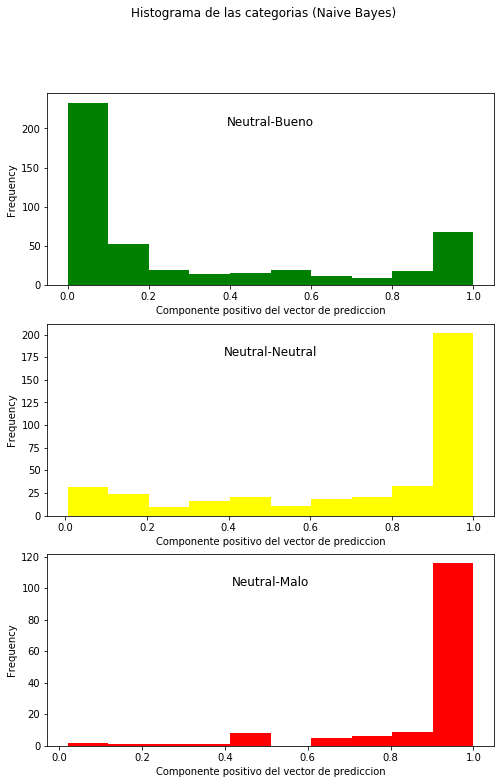

In [40]:
# Histogramas de cada categoria

hist_data_b = corpus_b["prediction"].map(lambda x: x[1])
hist_data_n = corpus_n["prediction"].map(lambda x: x[1])
hist_data_m = corpus_m["prediction"].map(lambda x: x[1])

fig = plt.figure(figsize=(8, 12))
fig.suptitle("Histograma de las categorias (Naive Bayes)")
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

n, bins, patches = ax1.hist(hist_data_b, color='green')
ax1.set_title("Neutral-Bueno", y=0.8)
ax1.set_xlabel('Componente positivo del vector de prediccion')
ax1.set_ylabel('Frequency')

n, bins, patches = ax2.hist(hist_data_n, color='yellow')
ax2.set_title("Neutral-Neutral", y=0.8)
ax2.set_xlabel('Componente positivo del vector de prediccion')
ax2.set_ylabel('Frequency')

n, bins, patches = ax3.hist(hist_data_m, color='red')
ax3.set_title("Neutral-Malo", y=0.8)
ax3.set_xlabel('Componente positivo del vector de prediccion')
ax3.set_ylabel('Frequency')


fig.savefig('./graphs/neutral_histogram_nb.png')